In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate
from simulators.cosmic_shear.cosmic_shear import *
import ndes.nde as nde
import distributions.priors as priors

/Users/charnock/.pyenv/versions/3.6.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [ ]:
### SET UP FOR SIMULATION CODE ###

# n(z)
#pz_fid = pickle.load(open('pz_euclid.pkl', 'rb'))
nz = 10
pz = np.loadtxt('simulators/cosmic_shear/pz.dat')
z = pz[0,:]
pz_fid = [0]*nz
for i in range(1, nz+1):
    pz_fid[i-1] = interpolate.InterpolatedUnivariateSpline(z, pz[i,:])

# Set up fiducial parameters and binning
theta_fiducial = np.array([0.3, 0.8, 0.05, 0.70, 0.96])
nz = 10
npar = 5
n_data = 5

# Define the priors
lower = np.array([0, 0.4, 0, 0.4, 0.7])
upper = np.array([1, 1.2, 0.1, 1.0, 1.3])
prior_mean = theta_fiducial
sigmas = np.zeros(npar)
sigmas[0:5] = np.array([0.1, 0.1, 0.05, 0.3, 0.3])
Q = np.eye(npar)*sigmas**2
Qinv = np.linalg.inv(Q)
prior_args = [prior_mean, Q, lower, upper]

# Parameter names and ranges for plotting  
names = ['\Omega_m', 'S_8', '\Omega_b', 'h', 'n_s']
labels =  ['\\Omega_m', 'S_8', '\\Omega_b', 'h', 'n_s']
ranges = {'\Omega_m':[lower[0], upper[0]], 'S_8':[lower[1],upper[1]],'\Omega_b':[lower[2],upper[2]],
            'h':[lower[3],upper[3]],'n_s':[lower[4],upper[4]]}

# Scale binning
lmax = 3000
lmin = 10
modes_edges = np.logspace(np.log10(lmin), np.log10(lmax), 11)
modes = (modes_edges[0:-1] + modes_edges[1:])/2
l = np.arange(lmin, lmax)
nl = np.array([sum((2*l[(l >= modes_edges[i])*(l < modes_edges[i+1])] + 1)) for i in range(len(modes))], dtype=int)

# Number of effective modes
A_sky = 15000*(np.pi/180)**2
f_sky = A_sky/(4*np.pi)
nl = np.array(nl*f_sky, dtype=int)

# Noise covariance
sigma_e = 0.3
nbar = 3*(60*180./np.pi)**2
N = (sigma_e**2/nbar)*np.eye(nz)

# Simulation arguments
sim_args = [pz_fid, modes, N, nl]

# Fiducial power spectrum
C = power_spectrum(theta_fiducial, sim_args)
Cinv = np.array([np.linalg.inv(C[:,:,l]) for l in range(len(modes))]).T

# Derivative of power spectrum
h = np.array(abs(theta_fiducial[0:5])*np.array([0.05, 0.05, 0.05, 0.05, 0.05]))
dCdt = np.zeros((npar, nz, nz, len(modes)))

# Derivatives wrt cosmological parameters
for i in range(npar):
    theta_plus = np.copy(theta_fiducial)
    theta_plus[i] += h[i]
    theta_minus = np.copy(theta_fiducial)
    theta_minus[i] -= h[i]
    
    Cp = power_spectrum(theta_plus, [pz_fid, modes, np.zeros((nz, nz))])
    Cm = power_spectrum(theta_minus, [pz_fid, modes, np.zeros((nz, nz))])
    C0 = power_spectrum(theta_fiducial, [pz_fid, modes, np.zeros((nz, nz))])

    dCdt[i, :, :, :] = (Cp - Cm)/(2*h[i])

# Fisher matrix
F, Finv, fisher_errors = fisher_matrix(Cinv, dCdt, npar, nl, Qinv)

# Projection arguments
projection_args = [Finv, 0, theta_fiducial, fisher_errors, prior_mean, Qinv, Cinv, dCdt, modes, nl]

# SimABC args
simABC_args = [sim_args, projection_args, prior_args]

In [19]:
# Define the simulator function: takes parameters, spits out simulated (compressed) summaries
simulator = lambda x, y: simulationABC(x, y)

In [5]:
# The data vector: import or otherwise simulate for testing
data = projected_score(power_spectrum(theta_fiducial, sim_args), projection_args)

In [6]:
# Create prior over parameters
prior = priors.TruncatedGaussian(prior_mean, Q, lower, upper)

# Create asymptotic posterior approximation
asymptotic_posterior = priors.TruncatedGaussian(theta_fiducial, Finv, lower, upper)

In [7]:
# Create the DELFI MDN object
n_components = 3
mdn = nde.DelfiMixtureDensityNetwork(simulator, prior, asymptotic_posterior, Finv, theta_fiducial, data, n_components, simulator_args = simABC_args, n_hidden = [50, 50], activations = [tf.nn.tanh, tf.nn.tanh], names = names, labels = labels, ranges = ranges)

Generating pre-training data...
Training on the pre-training data...



Done.
Sampling approximate posterior...
Done.
Saving fish_pretrain_post.pdf


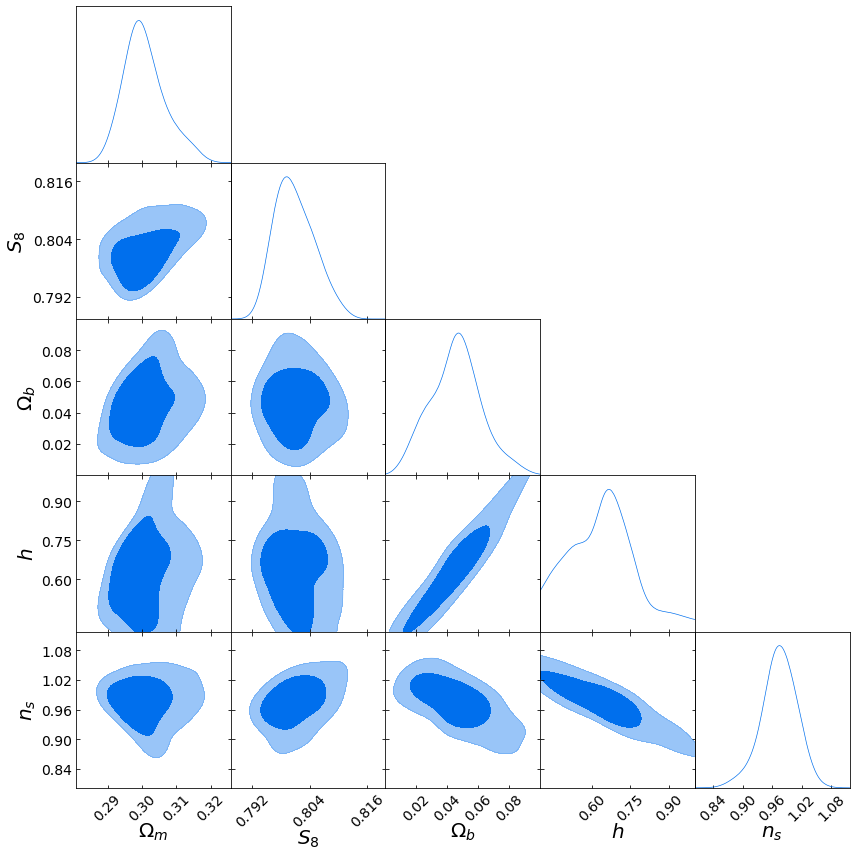

In [8]:
# Do the Fisher pre-training
mdn.sess.run(tf.global_variables_initializer())
mdn.fisher_pretraining(50000, prior, epochs=50, epsilon = 1e-37)

Running initial 500 sims...
Done.



Sampling approximate posterior...


/Users/charnock/Physics/delfi/ndes/nde.py:185: RuntimeWarning: divide by zero encountered in log
  return sampler.flatchain
/Users/charnock/Physics/delfi/ndes/nde.py:188: RuntimeWarning: divide by zero encountered in log
  def log_likelihood(self, theta):


Done.
Saving seq_train_post_0.pdf


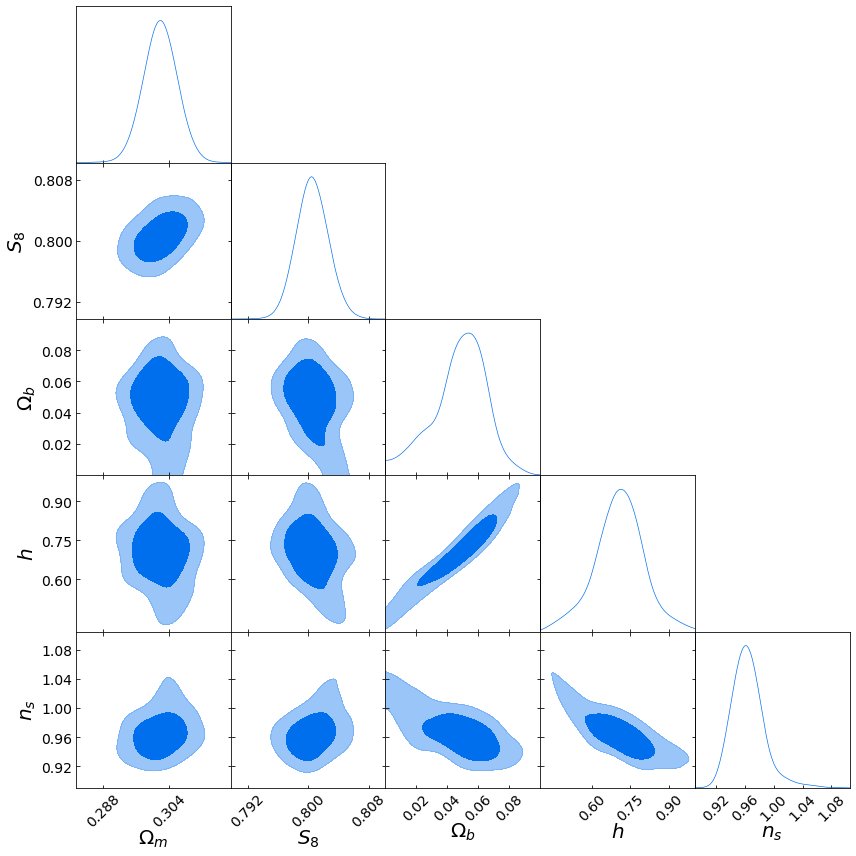

Population 1/15
Sampling proposal density...


/Users/charnock/Physics/delfi/ndes/nde.py:185: RuntimeWarning: divide by zero encountered in log
  return sampler.flatchain
/Users/charnock/Physics/delfi/ndes/nde.py:188: RuntimeWarning: divide by zero encountered in log
  def log_likelihood(self, theta):


Done.
Running 500 sims...
Done.



Sampling approximate posterior...
Done.
Saving seq_train_post_1.pdf


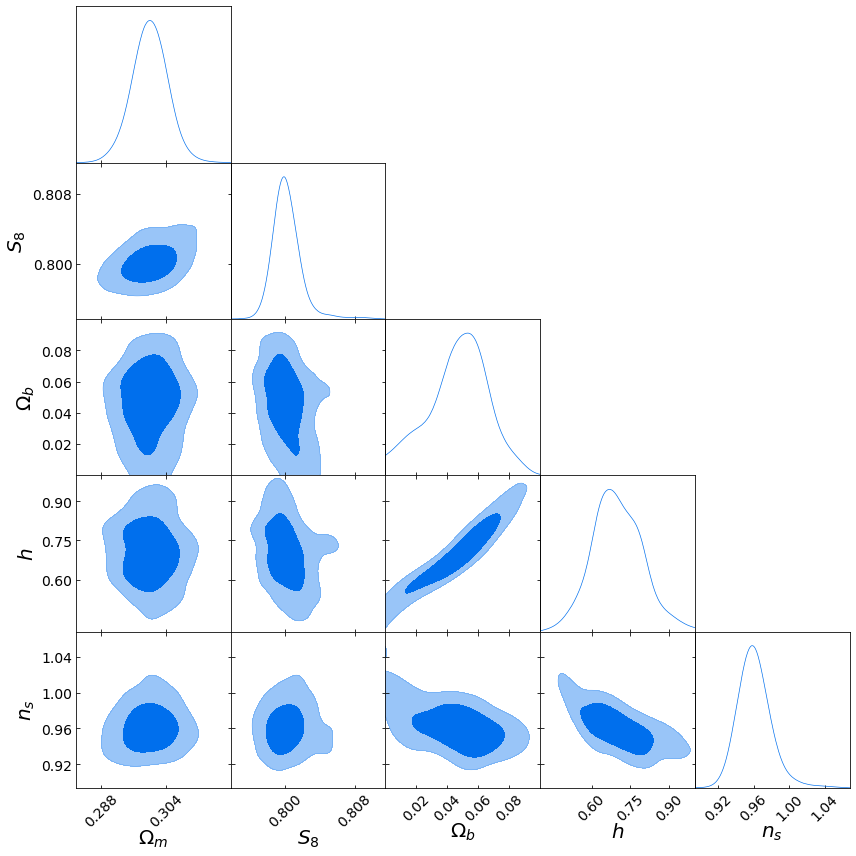

Population 2/15
Sampling proposal density...


/Users/charnock/Physics/delfi/ndes/nde.py:185: RuntimeWarning: divide by zero encountered in log
  return sampler.flatchain
/Users/charnock/Physics/delfi/ndes/nde.py:188: RuntimeWarning: divide by zero encountered in log
  def log_likelihood(self, theta):


Done.
Running 500 sims...
Done.



Sampling approximate posterior...
Done.
Saving seq_train_post_2.pdf


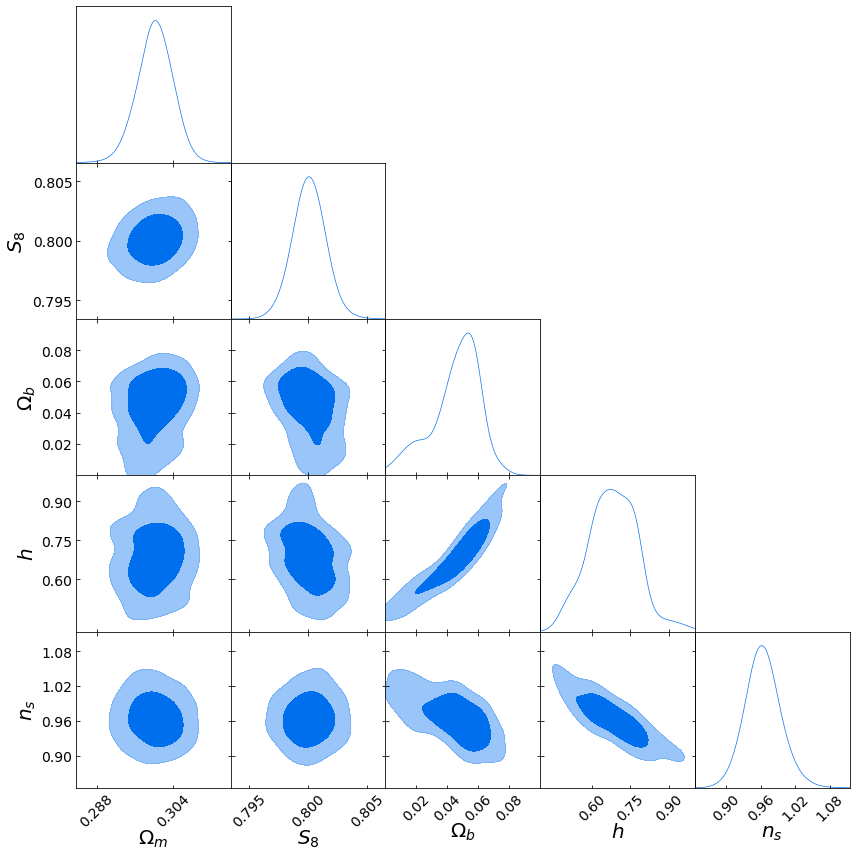

Population 3/15
Sampling proposal density...


/Users/charnock/Physics/delfi/ndes/nde.py:185: RuntimeWarning: divide by zero encountered in log
  return sampler.flatchain
/Users/charnock/Physics/delfi/ndes/nde.py:188: RuntimeWarning: divide by zero encountered in log
  def log_likelihood(self, theta):


Done.
Running 500 sims...
Done.



Sampling approximate posterior...
Done.
Saving seq_train_post_3.pdf


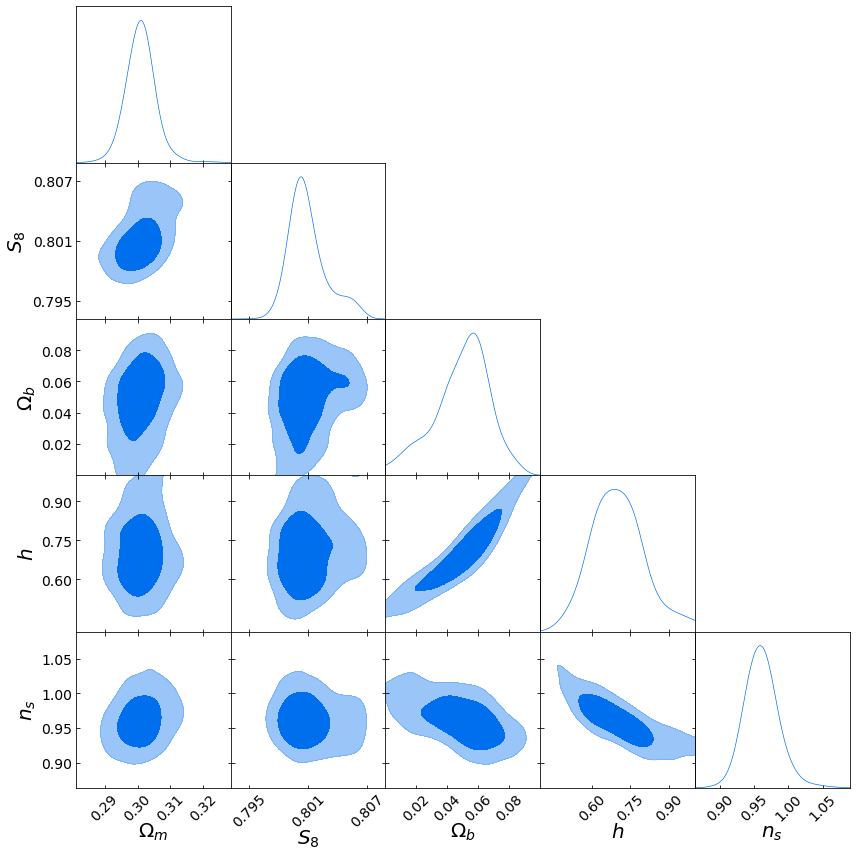

Population 4/15
Sampling proposal density...


/Users/charnock/Physics/delfi/ndes/nde.py:185: RuntimeWarning: divide by zero encountered in log
  return sampler.flatchain
/Users/charnock/Physics/delfi/ndes/nde.py:188: RuntimeWarning: divide by zero encountered in log
  def log_likelihood(self, theta):


Done.
Running 500 sims...
Done.



Sampling approximate posterior...
Done.
Saving seq_train_post_4.pdf


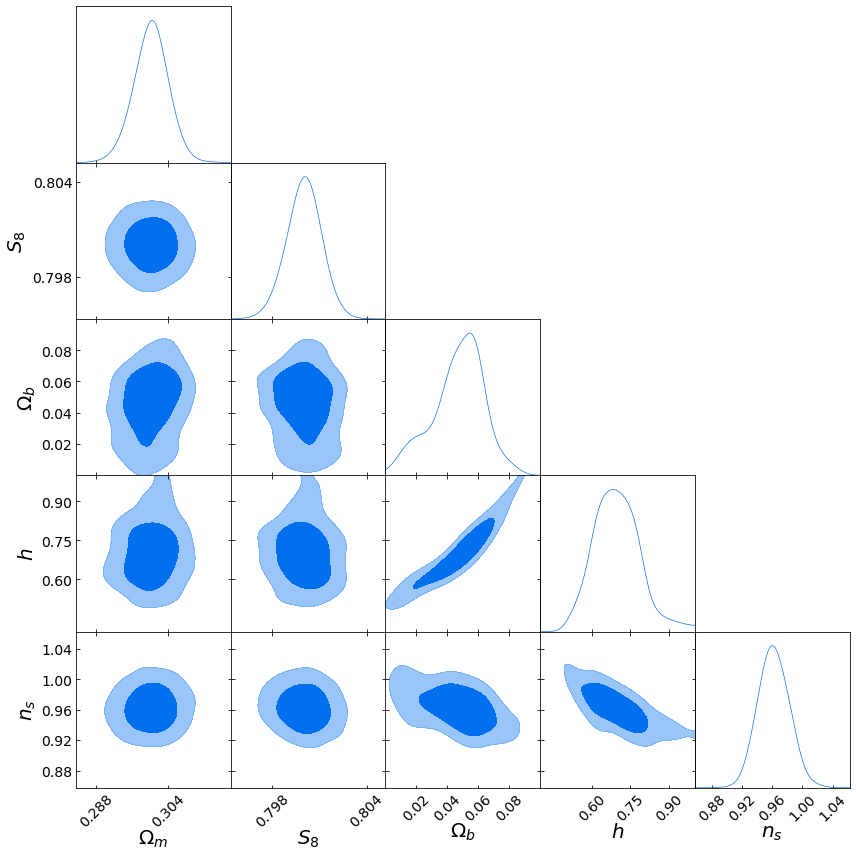

Population 5/15
Sampling proposal density...


/Users/charnock/Physics/delfi/ndes/nde.py:185: RuntimeWarning: divide by zero encountered in log
  return sampler.flatchain
/Users/charnock/Physics/delfi/ndes/nde.py:188: RuntimeWarning: divide by zero encountered in log
  def log_likelihood(self, theta):


Done.
Running 500 sims...


In [ ]:
# Proposal for the SNL
proposal = priors.TruncatedGaussian(theta_fiducial, 9*Finv, lower, upper)

# Initial samples, batch size for population samples, number of populations
n_initial = 500
n_batch = 500
n_populations = 15

# Do the SNL training
mdn.sequential_training(n_initial, n_batch, n_populations, proposal, epsilon = 1e-37)

In [ ]:
# Trace plot of the loss as a function of the number of simulations
plt.scatter(mdn.n_sim_trace, mdn.loss_trace, s = 20)
plt.plot(mdn.n_sim_trace, mdn.loss_trace, color = 'red')
plt.xlim(0, mdn.n_sim_trace[-1])
plt.xlabel('number of simulations')
plt.ylabel('loss')
plt.show()